In [2]:
import pandas as pd
import numpy as np

from seaborn import heatmap
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.drop(['Name'],axis = 'columns',inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


<Axes: >

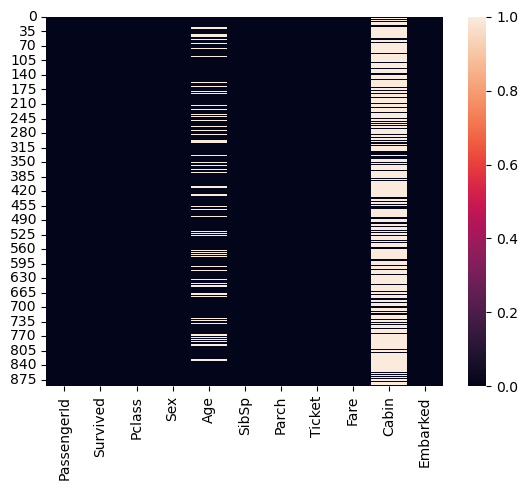

In [7]:
heatmap(df.isna())

<b>Embarked</b>, <b>Cabin</b> and <b>Age</b> attributes have missing values

## Data Cleaning

<b>Embarked</b>

In [8]:
df.dropna(subset = 'Embarked',axis = 0,inplace = True) #dropping the 2 rows with NaN's on embarked attribute

<b>Cabin</b>

In [9]:
total_instances = df.shape[0]
total_instances

889

In [10]:
cabin_missing = df['Cabin'].isna().sum()
cabin_missing

687

In [11]:
print('The percentage of missing values in the Cabin column is {} %'.format(np.around((cabin_missing*100)/total_instances),2))

The percentage of missing values in the Cabin column is 77.0 %


Due to the high percentage of missing data in the cabin column, it will be droped from the dataset.

In [12]:
df.drop(['Cabin'],axis = 'columns',inplace = True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,female,35.0,1,0,113803,53.1000,S
4,5,0,3,male,35.0,0,0,373450,8.0500,S


<b>Age</b>

In [13]:
age_missing = df['Age'].isna().sum()
age_missing 

177

In [14]:
print('The number of instances with age missing are {} %'.format(np.around(age_missing*100/total_instances )))

The number of instances with age missing are 20.0 %


To avoid lose more data and because 20% doesn't seem so high we're going to fill the missing values with the average of the age column

In [15]:
age_mean = df['Age'].mean()
df['Age'].fillna(value = age_mean,inplace = True)

In [16]:
df['Age'].notna().sum()

889

In [17]:
#Analysing the data for each column
for col in df.columns:
    print(df[col].value_counts().sort_values(ascending = False))

PassengerId
1      1
13     1
14     1
3      1
4      1
      ..
886    1
887    1
888    1
889    1
891    1
Name: count, Length: 889, dtype: int64
Survived
0    549
1    340
Name: count, dtype: int64
Pclass
3    491
1    214
2    184
Name: count, dtype: int64
Sex
male      577
female    312
Name: count, dtype: int64
Age
29.642088    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
            ... 
66.000000      1
0.666700       1
0.416700       1
34.500000      1
74.000000      1
Name: count, Length: 89, dtype: int64
SibSp
0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
Parch
0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
Ticket
347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
                   ..
2683                1
SOTON/O2 3101287    1
11774               1
392092              1
370376              1
Name: count

<b>Some Conclusions:</b>
<p>The ship had more males than females</p>
<p>The passengers on the ship came mainly from Southampton</p>
<p>The third class has more passengers than the other classes</p>

### Outliers

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: title={'center': 'Fare'}, xlabel='Fare'>

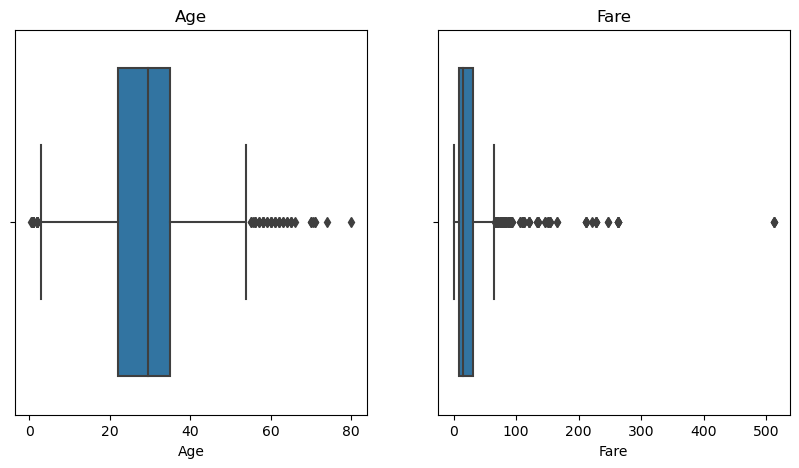

In [19]:
numerical_attributes = ['Age','Fare']
plt.figure(figsize = (10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('Age')
sns.boxplot(x = df[numerical_attributes[0]])
ax2 = plt.subplot(1,2,2)
ax2.set_title('Fare')
sns.boxplot(x = df[numerical_attributes[1]])


Above we can see that there is a fair number of outliers in these numerical attributes. We may treat them in the preprocessing

## EDA

In [20]:
categorical_attributes = df.drop(numerical_attributes,axis = 'columns').columns
categorical_attributes

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket',
       'Embarked'],
      dtype='object')

In [21]:
for col_name in df[categorical_attributes].columns:
    unique_cat = len(df[col_name].unique())
    print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name = col_name,unique_cat = unique_cat))

Feature 'PassengerId' has 889 unique categories
Feature 'Survived' has 2 unique categories
Feature 'Pclass' has 3 unique categories
Feature 'Sex' has 2 unique categories
Feature 'SibSp' has 7 unique categories
Feature 'Parch' has 7 unique categories
Feature 'Ticket' has 680 unique categories
Feature 'Embarked' has 3 unique categories


In [22]:
groupby_sex = df.groupby('Sex')

In [23]:
groupby_sex['Pclass'].value_counts(normalize = True)

Sex     Pclass
female  3         0.461538
        1         0.294872
        2         0.243590
male    3         0.601386
        1         0.211438
        2         0.187175
Name: proportion, dtype: float64

In [24]:
groupby_sex['Survived'].value_counts(normalize = True)

Sex     Survived
female  1           0.740385
        0           0.259615
male    0           0.811092
        1           0.188908
Name: proportion, dtype: float64

In [25]:
survivor_by_class = df.groupby('Survived')['Pclass'].value_counts()
survivor_by_class

Survived  Pclass
0         3         372
          2          97
          1          80
1         1         134
          3         119
          2          87
Name: count, dtype: int64

Text(0.5, 1.0, 'Passenger status by class')

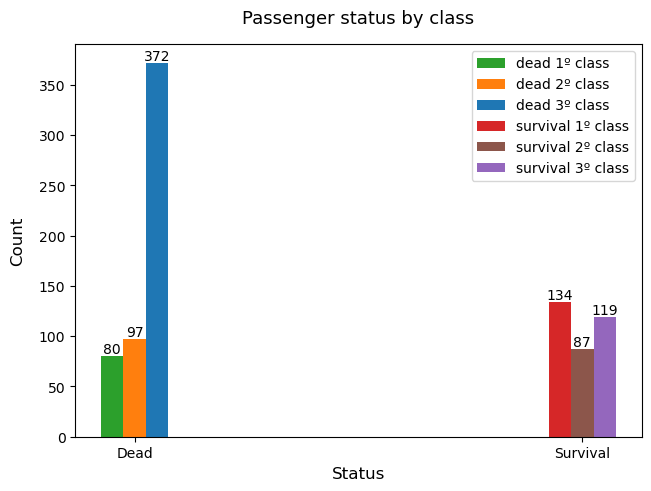

In [38]:
fig,ax = plt.subplots(layout = 'constrained')
width = 0.05

for key in survivor_by_class.keys():
    status_dic = {0:'dead',1:'survival'}
    # getting information from each status and class
    status = key[0]
    passenger_class = key[1]
    frequence = survivor_by_class[key]
    # preparing position of the bars
    multiplier = passenger_class
    offset = width*multiplier
    # plotting bars 
    rects = ax.bar(status+offset,frequence,width,label = '{} {}º class'.format(status_dic[status],passenger_class))
    ax.bar_label(rects)
      
#Sort legend       
handles,labels = ax.get_legend_handles_labels()
labels,handles = zip(*sorted(zip(labels,handles),key = lambda t:t[0]))
ax.legend(handles,labels)

ax.set_xticks(np.array([0.05,1.05]) + width,('Dead','Survival'))
ax.set_xlabel('Status',fontsize = 12)
ax.set_ylabel('Count',labelpad = 10,fontsize = 12)
ax.set_title('Passenger status by class',pad = 15,fontsize =13)

Above we can see that mainly people that were in thirst class died. However if there were more people on the third class it could be expected. <p>So we need to evaluate the relative value per class before taken some conclusion about it</p>

Text(0.5, 1.0, 'Passenger status by class')

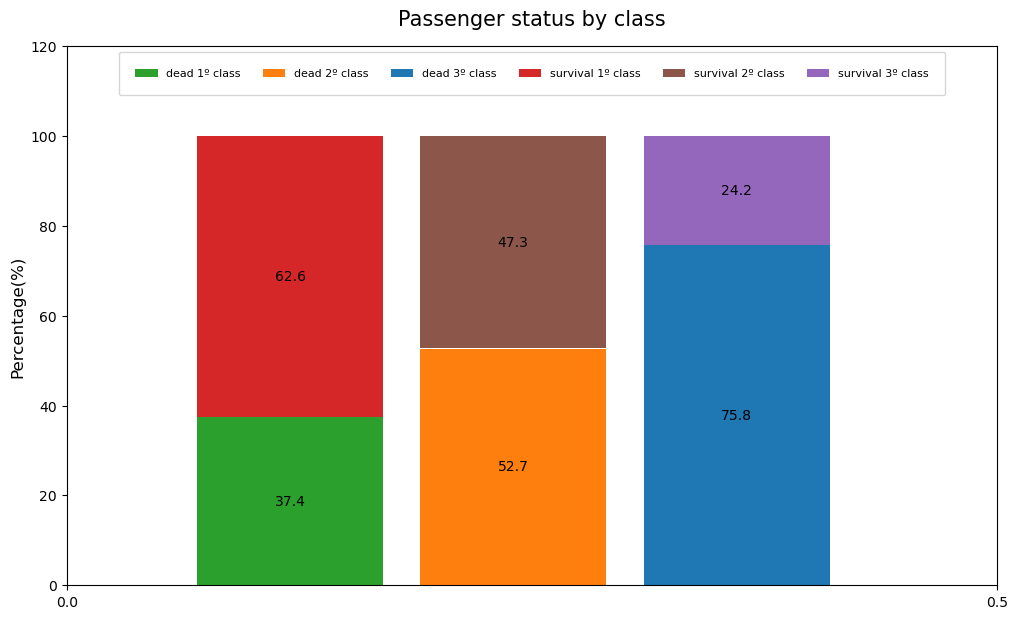

In [27]:
fig,ax = plt.subplots(figsize = (12,7))

width = 0.10
multiplier = 0
for i,key in enumerate(survivor_by_class.keys()):
    # getting information from each status and class
    status_dic = {0:'dead',1:'survival'} 
    status = key[0]
    passenger_class = key[1] 
    # calculating percentages
    frequence = survivor_by_class[key]
    total_class = survivor_by_class[(1,passenger_class)] + survivor_by_class[(0,passenger_class)]
    surv_percent = np.around((frequence*100)/total_class,1)
    # preparing position of the bars
    multiplier = passenger_class
    offset = width*multiplier*1.2
   
   # plotting bars according to the status

    if(status == 0):
        rects = ax.bar(offset,surv_percent,width,label = '{} {}º class'.format(status_dic[status],passenger_class))
        ax.bar_label(rects,label_type='center')
        
        
    elif(status == 1):
        rects = ax.bar(offset,surv_percent,width,bottom = survivor_by_class[(0,passenger_class)]*100/total_class,
                       label = '{} {}º class'.format(status_dic[status],passenger_class))
        ax.bar_label(rects,label_type='center')
    
    
#Sort legends
handles,labels = ax.get_legend_handles_labels()
labels,handles = zip(*sorted(zip(labels,handles),key = lambda t:t[0]))
ax.legend(handles,labels,loc = 'upper center',ncols = 6,fontsize = 8,borderpad = 1.5)

    

ax.set_xticks([0,0.5])
ax.set_yticks(np.arange(0,140,20))
ax.set_ylabel('Percentage(%)',fontsize = 12)
ax.set_title('Passenger status by class',pad = 15,fontsize = 15)

<b>Now is clear that the third class was the class with the higher percentage of dead passengers</b>

<b>Some conclusions:</b>
<p></p>
<p>There was more women than men in 1st class and men than women in 3rd class</p>
<p>Large part of people that died were men ( which can be correlated with the class they were embarked)</p>


## Pre processing

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [29]:
X_train,y_train = df.drop('Survived',axis=1),df['Survived'] #Splitting features and labels

The most part of machine learning algorithms work better with numerical data. Hence, we're going to encode some categorical attributes.

In [30]:
categorical_attributes = list(categorical_attributes)
categorical_attributes.pop(categorical_attributes.index('Survived')) #Taking off the label's name from the list
categorical_attributes

['PassengerId', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Embarked']

In [31]:
for col in categorical_attributes:
    if X_train[col].dtypes == 'object':
        print(X_train[col].value_counts())
    else:
        continue

Sex
male      577
female    312
Name: count, dtype: int64
Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 680, dtype: int64
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


In [32]:
#Enconding Sex
X_train['Sex'] = X_train['Sex'].map({'male':0,'female':1}) 

In [33]:
#Evaluating the number of categories in Ticket attribute
len(X_train['Ticket'].unique())

680

<p>The ticket attribute has 681 categories. We could try to encode this attribute, but it will slow down training since there is a large number of categories.</p>
<p>In addition the fare attribute can represent as well the kind of the ticket represented by the 'Ticket' attribute</p>

Hence we can drop it.

In [34]:
X_train.drop('Ticket',axis=1,inplace = True)

Embarked attribute isn't an ordinal category, so we may use one-hot enconding

In [35]:
cat_encoder = OneHotEncoder(handle_unknown='ignore')
embarked_encoded = cat_encoder.fit_transform(X_train[['Embarked']])
X_train[cat_encoder.categories_[0]] = embarked_encoded.toarray()
X_train.drop('Embarked',axis=1,inplace = True)

In [36]:
X_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,1,3,0,22.0,1,0,7.2500,0.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,0.0
2,3,3,1,26.0,0,0,7.9250,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,0.0,0.0,1.0
4,5,3,0,35.0,0,0,8.0500,0.0,0.0,1.0


## Select and Train a Model

In [63]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

At first, we're going to evaluate the accuracy for each model

In [139]:
results = []

In [140]:
def CrossVal(model,name,X_train,y_train):
    model.fit(X_train,y_train)
    scores = cross_val_score(model,X_train,y_train,cv = 10, scoring = 'accuracy').mean()
    results.append((name,scores))
    


In [141]:
sgd_cls = SGDClassifier()
sgd_scores = CrossVal(sgd_cls,'Stochastic Gradient Descendent',X_train,y_train)

tree_cls = DecisionTreeClassifier(min_samples_leaf=10)
tree_scores = CrossVal(tree_cls,'Decision Tree',X_train,y_train)

forest_cls = RandomForestClassifier()
tree_scores = CrossVal(forest_cls,'Random Forest',X_train,y_train)

accuracy = pd.DataFrame(results,columns = ['Model','Accuracy']).sort_values('Accuracy',ascending = False)
accuracy.set_index('Model',drop = True)

,Accuracy
Model,
Random Forest,0.822255
Decision Tree,0.806550
Stochastic Gradient Descendent,0.598519


<p>We can see that Random Forest has the best accuracy but we still need to check for other metrics.</p> 
<p>ROC curve will evaluate at what cost (False Positives) our model correctly classify survivors (True Positives) </p>

In [119]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

In [121]:
sgd_y_scores = cross_val_predict(sgd_cls,X_train,y_train,cv = 10,method = 'decision_function')
sgd_fpr,sgd_tpr,sgd_thresholds = roc_curve(y_train,sgd_y_scores)

In [142]:
tree_y_probas = cross_val_predict(tree_cls,X_train,y_train,cv=10,method = 'predict_proba')
tree_y_scores = tree_y_probas[:,1]
tree_fpr,tree_tpr,tree_thresholds = roc_curve(y_train,tree_y_scores)

In [127]:
forest_y_probas = cross_val_predict(forest_cls,X_train,y_train,cv = 10, method = 'predict_proba')
forest_y_scores = forest_y_probas[:,1] #Using the probability of an instance have a survivor as scores
forest_fpr,forest_tpr,forest_thresholds = roc_curve(y_train,forest_y_scores)

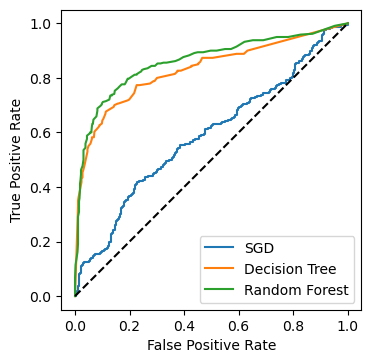

In [147]:
fig = plt.figure(figsize = (3,3))
ax = fig.add_axes([0,0,1,1])
ax.plot(sgd_fpr,sgd_tpr,label = 'SGD')
ax.plot(tree_fpr,tree_tpr,label = 'Decision Tree')
ax.plot(forest_fpr,forest_tpr,label = 'Random Forest')
ax.plot([0,1],[0,1],'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc = 'best')


## Fine-Tune the Model